# <span style="color: Teal; font-weight: bold">Modeling</span>

## <span style="color: Teal; font-weight: bold">Setup</span>

In [1]:
# Python library import block
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# Encoders and other important functions
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
#from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

# Custom functions from module
from extra_functions import cprint # colored print; makes some output a bit easier to read
from extra_functions import plotColumnCounts # bar plots (categorical) or histograms (numerical) for columns
from extra_functions import trim_feature # remove categories from a model if the total proportion represented is under a certain threshold (default: 1%)
from extra_functions import convert_range_to_avg

In [2]:
# import data objects for easy indexing
mainline_model = ['website_bool', 'support_url_bool', 'supported_languages_int', 'full_audio_languages_int']
target_features = ['price_log']
target_transformation = {'square_root': 'price'}

In [3]:
# import data from .csv files
df = pd.read_csv('data/model_mainline games.zip', compression = 'zip').set_index('AppID')
mainline_df = df[mainline_model]
catgen_df = pd.read_csv('data/model_catgen.csv').set_index('AppID')
tags_num_df = pd.read_csv('data/model_tags_numeric.csv').set_index('index')
tags_bool_df = pd.read_csv('data/model_tags_bool.csv').set_index('index')

## <span style="color: Teal; font-weight: bold">Preparation</span>

I have four predictive models that I can test, that may be able to be combined. At the moment, I will keep them separate to reduce dimensionality during modeling.

- Mainline model: DF with 5 features realted to whether gaves have a website, support information, and how many langauges they have available.
- Categories/Genres model: DF with 64 game categories and genres. All Boolean, so 1/0.
- Tags - Numeric model: DF with 30 features, consisting of the 30 most present game tags. This has the raw number of tags per game.
- Tags - Boolean model: DF with 30 features, like the 'Tags - Numeric model', but all values are 1/0.

After initial modeling, I may take the highest-performing features and run one final model, including everything.

I have one target feature:
- `price_log`: The natural log of the price (transformed to make the variable a bit more normal)

**Strategy**:
There are two classes of models I will be using.
- Regression: To predict `price_log`. Use multiple regression for these to begin with.

For modeling, I will use cross-validation methods, and have a final holdout sample to see how well the model performs.

**Transformation steps**
The following steps will be conducted to transform and prep the data for modeling:

1) Set aside 10% of the data for testing final models
2) Set up modeling pipelines
3) Model data

### <span style="color: Teal; font-weight: bold">Feature Transformation Prep

In [4]:
target_df = df[target_features]
target_df.head()

,price_log
AppID,
359550,2.995232
252490,3.688629
1091500,3.400864
553850,3.688629
413150,2.707383


In [5]:
X_main, X2_main, X_catgen, X2_catgen, X_tags_num, X2_tags_num, X_tags_bool, X2_tags_bool, y_train, y_test  = train_test_split(mainline_df, catgen_df, tags_num_df, tags_bool_df, target_df, test_size = 0.1, random_state = 42)
print(X_main.shape[0])
print(X2_main.shape[0])

14296
1589


### <span style="color: Teal; font-weight: bold">Modeling Pipelines</span>

Create column transformers and pipelines for each of the four predictive models.

In [6]:
main_ct = ColumnTransformer(
    transformers = [('std', StandardScaler(), X_main.columns)],
    remainder = 'passthrough')
tags_num_ct = ColumnTransformer(
    transformers = [('std', StandardScaler(), X_tags_num.columns)],
    remainder = 'passthrough')

## <span style="color: Teal; font-weight: bold">Models - Linear Regression</span>

In [7]:
main_pipe_ridge = Pipeline([('xform', main_ct), ('ridge', Ridge())])
catgen_pipe_ridge = Pipeline([('poly', PolynomialFeatures(degree = 2, include_bias = False)), ('ridge', Ridge())])
tags_num_ridge = Pipeline([('xform', tags_num_ct,), ('ridge', Ridge())])
tags_bool_ridge = Pipeline([('ridge', Ridge())])

#### <span style="color: Teal; font-weight: bold">Modeling</span>

In [8]:
target_features

['price_log']

In [9]:
best_price_features = {}

In [10]:
## Mainline model
ridge_parameters = {'ridge__alpha': 10**np.linspace(-3, 3, 7)}

main_grid_ridge = GridSearchCV(main_pipe_ridge, ridge_parameters, cv = 5, scoring='r2', verbose=1)
main_grid_ridge.fit(X_main, y_train['price_log'])
main_grid_ridge.score(X2_main, y_test['price_log'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.02029148178570328

In [11]:
main_ridge_results = pd.DataFrame({'feature': main_grid_ridge.feature_names_in_, 'coef': main_grid_ridge.best_estimator_['ridge'].coef_}).set_index('feature')
main_ridge_results.sort_values('coef', ascending = False)

,coef
feature,
supported_languages_int,0.048248
support_url_bool,0.020613
website_bool,0.019944
full_audio_languages_int,0.007206


In [12]:
best_price_features['main'] = list(main_ridge_results.index[np.abs(main_ridge_results['coef']) > .05])
best_price_features

{'main': []}

In [13]:
## Catgen model
ridge_parameters = {'ridge__alpha': 10**np.linspace(-3, 3, 7)}

catgen_grid_ridge = GridSearchCV(catgen_pipe_ridge, ridge_parameters, cv = 5, scoring='r2', verbose=1)
catgen_grid_ridge.fit(X_catgen, y_train['price_log'])
catgen_grid_ridge.score(X2_catgen, y_test['price_log'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.12941585106438303

In [14]:
catgen_ridge_results = pd.DataFrame({'feature': catgen_grid_ridge.best_estimator_.named_steps['poly'].get_feature_names_out(), 'coef': catgen_grid_ridge.best_estimator_['ridge'].coef_}).set_index('feature')
catgen_ridge_results.sort_values('coef',ascending=False)

,coef
feature,
genres_indie genres_casual,0.055904
categories_full_controller_support categories_steam_achievements,0.054783
categories_steam_achievements categories_partial_controller_support,0.052557
categories_single-player categories_multi-player,0.050585
categories_steam_achievements genres_rpg,0.047097
categories_steam_cloud genres_adventure,0.046754
genres_rpg genres_early_access,0.044985
genres_indie genres_early_access,0.043964
categories_online_pvp categories_full_controller_support,0.039808


In [15]:
best_price_features['catgen'] = list(catgen_ridge_results.index[np.abs(catgen_ridge_results['coef']) > .05])
best_price_features

{'main': [],
 'catgen': ['categories_family_sharing',
  'categories_single-player categories_multi-player',
  'categories_full_controller_support categories_steam_achievements',
  'categories_steam_trading_cards categories_remote_play_together',
  'categories_steam_achievements categories_partial_controller_support',
  'categories_steam_achievements genres_indie',
  'categories_steam_achievements genres_casual',
  'categories_steam_cloud genres_indie',
  'categories_family_sharing^2',
  'genres_indie genres_casual']}

In [16]:
## tags_num model
ridge_parameters = {'ridge__alpha': 10**np.linspace(-3, 3, 7)}

tags_num_grid_ridge = GridSearchCV(tags_num_ridge, ridge_parameters, cv = 5, scoring='r2', verbose=1)
tags_num_grid_ridge.fit(X_tags_num, y_train['price_log'])
tags_num_grid_ridge.score(X2_tags_num, y_test['price_log'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.019960208859291506

In [17]:
tags_num_ridge_results = pd.DataFrame({'feature': tags_num_grid_ridge.feature_names_in_, 'coef': tags_num_grid_ridge.best_estimator_['ridge'].coef_}).set_index('feature')
tags_num_ridge_results.sort_values('coef', ascending=False)

,coef
feature,
Simulation,0.025140
Singleplayer,0.021018
Anime,0.020440
Action,0.017363
Open World,0.014581
RPG,0.013210
Strategy,0.009891
Multiplayer,0.008391
Third Person,0.008107


In [18]:
# Don't add anything from this model

In [19]:
## tags_bool model
ridge_parameters = {'ridge__alpha': 10**np.linspace(-3, 3, 7)}

tags_bool_grid_ridge = GridSearchCV(tags_bool_ridge, ridge_parameters, cv = 5, scoring='r2', verbose=1)
tags_bool_grid_ridge.fit(X_tags_bool, y_train['price_log'])
tags_bool_grid_ridge.score(X2_tags_bool, y_test['price_log'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.10660713340922878

In [20]:
tags_bool_grid_results = pd.DataFrame({'feature': tags_bool_grid_ridge.feature_names_in_, 'coef': tags_bool_grid_ridge.best_estimator_['ridge'].coef_}).set_index('feature')
tags_bool_grid_results.sort_values('coef', ascending=False)

,coef
feature,
Anime,0.089530
Multiplayer,0.088745
Singleplayer,0.068367
Simulation,0.058912
Open World,0.052217
Story Rich,0.040510
Third Person,0.028491
RPG,0.020112
Action,0.019720


In [21]:
best_price_features['tags_bool'] = list(tags_bool_grid_results.index[np.abs(tags_bool_grid_results['coef']) > .05])
best_price_features

{'main': [],
 'catgen': ['categories_family_sharing',
  'categories_single-player categories_multi-player',
  'categories_full_controller_support categories_steam_achievements',
  'categories_steam_trading_cards categories_remote_play_together',
  'categories_steam_achievements categories_partial_controller_support',
  'categories_steam_achievements genres_indie',
  'categories_steam_achievements genres_casual',
  'categories_steam_cloud genres_indie',
  'categories_family_sharing^2',
  'genres_indie genres_casual'],
 'tags_bool': ['Singleplayer',
  'Indie',
  'Casual',
  'Simulation',
  '2D',
  'Early Access',
  'Multiplayer',
  'Anime',
  'Puzzle',
  'Open World',
  'Pixel Graphics']}

In [22]:
# create a catgen df with polynomial features, to concatenate for main model
catgen_xform = pd.DataFrame(PolynomialFeatures(degree = 2, include_bias = False).fit_transform(catgen_df), columns=catgen_grid_ridge.best_estimator_.named_steps['poly'].get_feature_names_out(), index = catgen_df.index)

main_model_final = pd.concat([mainline_df[best_price_features['main']], catgen_xform[best_price_features['catgen']], tags_bool_df[best_price_features['tags_bool']]], axis = 1)
#pd.concat([X_main[best_price_features['main']], catgen_xform[best_price_features['catgen']], X_tags_bool[best_price_features['tags_bool']]], axis = 1)

main_colcheck = []
for temp_model_type in best_price_features.values():
    if isinstance(temp_model_type, list):
        for temp_colname in temp_model_type:
            main_colcheck.append(temp_colname in main_model_final.columns)
    else:
        main_colcheck.append(temp_model_type in main_model_final.columns)

all(main_colcheck)

True

#### <span style="color: Teal; font-weight: bold">Final Model</span>

After further consideration, I decided to create a model that included all features, and not just those that were the most predictive.

In [23]:
# create a catgen df with polynomial features, to concatenate for main model
catgen_xform = pd.DataFrame(PolynomialFeatures(degree = 2, include_bias = False).fit_transform(catgen_df), columns=catgen_grid_ridge.best_estimator_.named_steps['poly'].get_feature_names_out(), index = catgen_df.index)

main_model_final = pd.concat([mainline_df, catgen_xform, tags_bool_df], axis = 1)
#pd.concat([X_main[best_price_features['main']], catgen_xform[best_price_features['catgen']], X_tags_bool[best_price_features['tags_bool']]], axis = 1)

main_colcheck = []
for temp_model_type in best_price_features.values():
    if isinstance(temp_model_type, list):
        for temp_colname in temp_model_type:
            main_colcheck.append(temp_colname in main_model_final.columns)
    else:
        main_colcheck.append(temp_model_type in main_model_final.columns)

print(all(main_colcheck))
main_model_final.shape

True


(15885, 243)

In [24]:
# run GridSearchCV for ridge model
X_ridge_final, X2_ridge_final, y_ridge_train, y_ridge_test = train_test_split(main_model_final, df['price_log'], test_size = 0.1, random_state = 42)

### pipeline: (1) polynomial transformation for catgen, (2) standard scaler for all, (3) ridge regression
main_final_ct = ColumnTransformer(
    transformers = [('std', StandardScaler(), X_ridge_final.columns)],
    remainder = 'passthrough')

main_final_pipe_ridge = Pipeline([('xform', main_final_ct), ('ridge', Ridge())])

ridge_parameters = {'ridge__alpha': 10**np.linspace(-3, 3, 7)}

main_final_grid_ridge = GridSearchCV(main_final_pipe_ridge, ridge_parameters, cv = 5, scoring='r2', verbose=1)
main_final_grid_ridge.fit(X_ridge_final, y_ridge_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('std',
                                                                         StandardScaler(),
                                                                         Index(['website_bool', 'support_url_bool', 'supported_languages_int',
       'full_audio_languages_int', 'categories_single-player',
       'categories_multi-player', 'categories_online_pvp',
       'categories_full_controller_support', 'categories_steam_trading_cards',
       'categories_steam_achievements',
       ...
       'Puzzle', 'Female Protagonist', 'Open World', 'Sci-fi',
       'Pixel Graphics', 'Funny', 'Action-Adventure', 'Shooter',
       'Third Person', 'Sandbox'],
      dtype='object', length=243))])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='r2', verbose=1)

In [35]:
main_final_ridge_rmse = np.sqrt(mean_squared_error(main_final_grid_ridge.predict(X2_ridge_final), y_ridge_test))
main_final_ridge_rmse_original = np.sqrt(mean_squared_error(np.log(main_final_grid_ridge.predict(X2_ridge_final)), np.log(y_ridge_test)))

print(f"RMSE: {main_final_ridge_rmse}\nRMSE in terms of original dollar price: ${round(main_final_ridge_rmse_original,4)}\nR^2 value: {main_final_grid_ridge.score(X2_ridge_final, y_ridge_test)}")

RMSE: 0.31300913845836426
RMSE in terms of original dollar price: $0.1054
R^2 value: 0.1598985950244467


#### <span style="color: Teal; font-weight: bold">Summary</span>

The RMSE of this final model for predicting `price_log` is ~. The unit of `price_log` is the log of dollar price; converting the units to original dollar price, the model's RMSE corresponds to . This seems like a small margin of error given that the R^2 value for the model is only not bad, but not perfect at all.

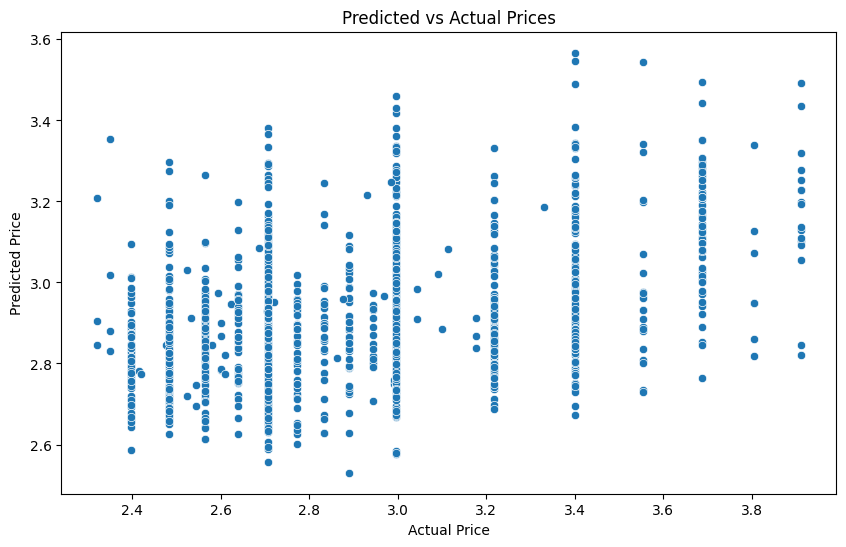

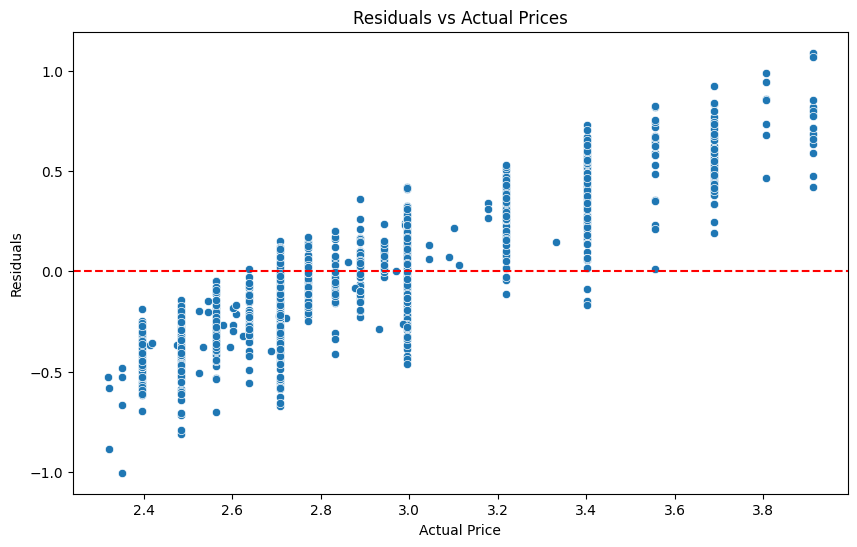

In [32]:
# plot the model's residuals
main_final_ridge_resid = pd.DataFrame({'Actual': y_ridge_test, 'Predicted': main_final_grid_ridge.predict(X2_ridge_final), 'Residuals': y_ridge_test - main_final_grid_ridge.predict(X2_ridge_final)})

plt.figure(figsize = (10,6))
sns.scatterplot(x='Actual', y='Predicted', data=main_final_ridge_resid)
#plt.plot([2, 4], [-1, 1], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Prices')
plt.savefig('images/ridge_predicted_actual.png')
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Residuals', data=main_final_ridge_resid)
plt.axhline(0, color='red', linestyle='--')  # Line at zero
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Prices')
plt.savefig('images/ridge_actual_residuals.png')
plt.show()

The model seems to essentially be guessing the mean; there's not enough variance in the predicted values.

The next step is to see if tactics like random forest XGBoost, SVM, or DNNs produce better results

# Compare to Dummy regressor

In [36]:
from sklearn.dummy import DummyRegressor
dummy_regressor_median = DummyRegressor(strategy="median")
dummy_regressor_median.fit(X_ridge_final, y_ridge_train)
y_pred_median = dummy_regressor_median.predict(X_ridge_final)

mse_median = mean_squared_error(y_ridge_train, y_pred_median)
r2_median = r2_score(y_ridge_train, y_pred_median)

print(f"RMSE (Median Strategy): {np.sqrt(mse_median)}")
print(f"R-squared (Median Strategy): {r2_median}")

RMSE (Median Strategy): 0.35811928387715597
R-squared (Median Strategy): -0.04798896349391879


In [37]:
from sklearn.dummy import DummyRegressor
dummy_regressor_median = DummyRegressor(strategy="mean")
dummy_regressor_median.fit(X_ridge_final, y_ridge_train)
y_pred_median = dummy_regressor_median.predict(X_ridge_final)

mse_median = mean_squared_error(y_ridge_train, y_pred_median)
r2_median = r2_score(y_ridge_train, y_pred_median)

print(f"RMSE (Mean Strategy): {np.sqrt(mse_median)}")
print(f"R-squared (Mean Strategy): {r2_median}")

RMSE (Mean Strategy): 0.34982379983512907
R-squared (Mean Strategy): 0.0
